In [22]:
import numpy as np

# 假设有 3 台机器和 3 个操作
m = 3  # 机器数量
N = 2  # 表示机器的二进制 (0, 1)
n = 2  # 操作数量
l = 1  # 用于表示 C_max 的二进制位数
# 处理时间矩阵 (例如)
p = np.array([[1, 2, 3], [2, 3, 1]])

b = np.array([[0, 0], [1, 0], [0, 1]])
# 非法数组(用于表示机器数)(1, 1)
bw = np.array([[1, 1]])
# 常数
K1 = 100
P = 30
# print(len(bw))
# 量子比特数量
num_qubits = n * N + l

In [23]:
# def pauli_z_term(index, num_qubits):
#     """初始化一个 Pauli-I 门的列表,指定索引 index 替换为 Pauli-Z 门"""
#     paulis = ['I'] * num_qubits
#     paulis[index] = 'Z'
#     return ''.join(paulis)  # 将列表转化为字符串
def pauli_z_term(indices, num_qubits):
    """生成 Pauli-Z 项"""
    z_str = ['I'] * num_qubits
    for idx in indices:
        z_str[idx] = 'Z'
    return ''.join(z_str)


def pauli_x_term(index, num_qubits):
    paulis = ['I'] * num_qubits
    paulis[index] = 'X'
    return ''.join(paulis)

In [24]:
from qiskit.quantum_info import SparsePauliOp

# 初始化 Pauli 字符串和系数
pauli_strings = []
coefficients = []

# 构建哈密顿量
for h in range(l):
    coef = - 2 ** h / 2  # 系数为 2^h
    z_term = ['I'] * num_qubits
    z_term[n * N + h] = 'Z'  # 第 n * N + h 位是 Z，其余是 I
    pauli_strings.append(''.join(z_term))
    coefficients.append(coef)

# 转换为 SparsePauliOp 格式
hamiltonian1 = SparsePauliOp.from_list(list(zip(pauli_strings, coefficients)))

# 输出结果
print("哈密顿量:")
print(hamiltonian1)

哈密顿量:
SparsePauliOp(['IIIIZ'],
              coeffs=[-0.5+0.j])


In [25]:
from itertools import combinations

# 初始化哈密顿量参数
pauli_strings = []
coefficients = []

# 遍历 j 和 i
for j in range(len(bw)):
    for i in range(n):
        # 枚举 k 的所有子集
        for subset_size in range(N + 1):  # 子集大小
            for subset in combinations(range(N), subset_size):
                # 计算子集 S 的系数
                coef = K1
                for k in subset:
                    coef *= (0.5 - b[j][k])  # 子集 S 中的项
                for k in range(N):
                    if k not in subset:
                        coef *= 0.5  # 非子集项的贡献

                # 生成对应的 Pauli-Z 项
                indices = [i * N + k for k in subset]  # 转为量子比特索引
                z_term = pauli_z_term(indices, num_qubits)

                # 添加到哈密顿量
                pauli_strings.append(z_term)
                coefficients.append(coef)

# 转换为 SparsePauliOp 格式
hamiltonian2 = SparsePauliOp.from_list(list(zip(pauli_strings, coefficients)))

# 输出结果
print("哈密顿量:")
print(hamiltonian2)

哈密顿量:
SparsePauliOp(['IIIII', 'ZIIII', 'IZIII', 'ZZIII', 'IIIII', 'IIZII', 'IIIZI', 'IIZZI'],
              coeffs=[25.+0.j, 25.+0.j, 25.+0.j, 25.+0.j, 25.+0.j, 25.+0.j, 25.+0.j, 25.+0.j])


In [26]:
# 初始化参数
pauli_strings = []
coefficients = []

# 第一部分：双重乘积项
for j in range(m):
    for i in range(n):
        for i_prime in range(n):
            coef = p[i, j] * p[i_prime, j] / (2 ** (2 * N))
            z_term = ['I'] * num_qubits
            for k in range(N):
                if b[j, k] == 1:
                    z_term[i * N + k] = 'Z'
                    z_term[i_prime * N + k] = 'Z'
            pauli_strings.append(''.join(z_term))
            coefficients.append(coef)

# 第二部分：结合时间和二进制位
for j in range(m):
    for i in range(n):
        for h in range(l):
            coef = -2 * p[i, j] * (2 ** (h - 1)) / (2 ** N)
            z_term = ['I'] * num_qubits
            for k in range(N):
                if b[j, k] == 1:
                    z_term[i * N + k] = 'Z'
            z_term[n * N + h] = 'Z'
            pauli_strings.append(''.join(z_term))
            coefficients.append(coef)

# 第三部分：纯二进制项
for h in range(l):
    for h_prime in range(l):
        coef = 2 ** (h - 1) * 2 ** (h_prime - 1)
        z_term = ['I'] * num_qubits
        if h == h_prime:
            z_term[n * N + h] = 'Z'
            pauli_strings.append(''.join(z_term))
            coefficients.append(coef)
        else:
            z_term1 = z_term.copy()
            z_term2 = z_term.copy()
            z_term1[n * N + h] = 'Z'
            z_term2[n * N + h_prime] = 'Z'
            pauli_strings.append(''.join(z_term1))
            coefficients.append(-coef)
            pauli_strings.append(''.join(z_term2))
            coefficients.append(-coef)
            z_term1[n * N + h_prime] = 'Z'
            pauli_strings.append(''.join(z_term1))
            coefficients.append(coef)

# 转换为 SparsePauliOp 格式
hamiltonian3 = SparsePauliOp.from_list(list(zip(pauli_strings, coefficients)))

# 输出结果
print("哈密顿量:")
print(hamiltonian3)

哈密顿量:
SparsePauliOp(['IIIII', 'IIIII', 'IIIII', 'IIIII', 'ZIIII', 'ZIZII', 'ZIZII', 'IIZII', 'IZIII', 'IZIZI', 'IZIZI', 'IIIZI', 'IIIIZ', 'IIIIZ', 'ZIIIZ', 'IIZIZ', 'IZIIZ', 'IIIZZ', 'IIIIZ'],
              coeffs=[ 0.0625+0.j,  0.125 +0.j,  0.125 +0.j,  0.25  +0.j,  0.25  +0.j,
  0.375 +0.j,  0.375 +0.j,  0.5625+0.j,  0.5625+0.j,  0.1875+0.j,
  0.1875+0.j,  0.0625+0.j, -0.25  +0.j, -0.5   +0.j, -0.5   +0.j,
 -0.75  +0.j, -0.75  +0.j, -0.25  +0.j,  0.25  +0.j])


In [27]:
cost_hamiltonian = hamiltonian1 + hamiltonian2 + hamiltonian3

In [28]:
def append_multi_rzz_term(qc, qubits, gamma):
    """
    构建一个类RZZ门，n-1个控制位，1个目标位，进行旋转操作。
    参数:
    control_qubits: List[int]，控制量子比特的索引
    target_qubit: int，目标量子比特的索引
    """
    if len(qubits) == 1:
        qc.rz(gamma, qubits[0])
    else:
        control_qubits = qubits[:N - 1]

        target_qubit = qubits[N - 1:]

        n_controls = len(control_qubits)
        if n_controls == 1:
            qc.cx(control_qubits[0], target_qubit[0])
        else:
            qc.mcx(control_qubits, target_qubit[0])
        qc.rz(gamma, target_qubit[0])
        if n_controls == 1:
            qc.cx(control_qubits[0], target_qubit[0])
        else:
            qc.mcx(control_qubits, target_qubit[0])

In [29]:
def append__zz_term(qc, qubit1, qubit2, gamma):
    qc.cx(qubit1, qubit2)
    qc.rz(gamma, qubit2)
    qc.cx(qubit1, qubit2)


def append__z_term(qc, qubit, gamma):
    qc.rz(gamma, qubit)


def append__mixer_term(qc, qubit, beta):
    qc.rx(2 * beta, qubit)

In [30]:
def get_cost_circuit1(gamma, qc):
    for h in range(l):
        coef = - 2 ** h
        append__z_term(qc, N * n + h, coef * gamma)
    return qc

\begin{align}K_{1} \sum_{j\in W} \sum_{i=0}^{n}\prod_{k=0}^{N}\left(\frac{1}2+\left(\frac{1}2-b_{j k}\right)Z_{ik}\right)\end{align}

In [31]:
import itertools


def get_cost_circuit2(gamma, qc):
    # print(len(bw))
    if len(bw) == 0:
        return qc
    all_combinations = list(itertools.chain(*(itertools.combinations(range(N), r) for r in range(1, N + 1))))
    for j in range(len(bw)):
        for i in range(n):
            constant = 1 / (2 ** N)  # 系数 1/2^N  
            for qubit_indices in all_combinations:  # 遍历各种组合
                qubits_index = np.array([], dtype=int)
                # 根据组合项生成子项的常数和qubit索引
                for k in range(N):
                    constant *= (1 - 2 * bw[j, k]) if k in qubit_indices else 1
                    if k in qubit_indices:
                        qubits_index = np.append(qubits_index, i * N + k)
                # print("qubits_index", qubits_index)
                append_multi_rzz_term(qc, qubits_index, 2 * K1 * constant * gamma)
    return qc


In [32]:
# from qiskit import Aer, QuantumCircuit, execute
# gamma= 1
# qc = QuantumCircuit(num_qubits, num_qubits)
# # qc.h(range(num_qubits))
# # print(qc)
# get_cost_circuit2(gamma, qc)
# print(qc)
# qc.decompose().draw('mpl')

\begin{align}\sum_{j=0}^{m-1}\sum_{i=0}^{n-1} \sum_{i^{\prime}=0}^{n-1}\left(\prod_{k=0}^{N-1}\frac{1}{2}\left(1+\left(1-2b_{j k}\right) Z_{i k}\right)\right) p_{i j}\left(\prod_{k^{\prime}=0}^{N-1}\frac{1}{2}\left(1+\left(1-2b_{j k}\right) Z_{i^{\prime} k^{\prime}}\right)\right) p_{i^{\prime} j}\end{align}
\begin{align}-2 \sum_{j=0}^{m-1} \sum_{i=0}^{n-1} \sum_{h=0}^{l-1} \left(\prod_{k=0}^{N-1}\frac{1}{2}\left(1+\left(1-2b_{j k}\right) Z_{i k}\right)\right) p_{i j} \cdot 2^{h-1}\left(1-Z_h\right)\end{align}
\begin{align}\sum_{j=0}^{m-1}\sum_{h=0}^{l-1} \sum_{h^{\prime}=0}^{l-1} 2^{h-1} 2^{h^{\prime}-1}\left(1-Z_h-Z_{h^{\prime}}+Z_h Z_{h^{\prime}}\right)\end{align}

In [33]:
# import itertools
from collections import Counter


def get_cost_circuit3(gamma, qc):
    for j in range(len(b)):
        # 对应12, 13, 23, 45, 46, 56
        for i in range(n):  # 自身内部相乘，对应12, 13, 23, 45, 46, 56
            all_combinations_1 = list(itertools.chain(*(itertools.combinations(range(N), r) for r in range(1, N + 1))))
            # 获取 all_combinations_1 中任意两项的所有组合
            all_two_combinations = list(itertools.combinations(all_combinations_1, 2))
            for qubit_indices in all_two_combinations:  # 遍历各种组合
                # print("qubit_indices", qubit_indices)
                # sub_constant = constant
                qubits_index = np.array([], dtype=int)
                constant = 1
                # 将组合对中的每个元素（每个元素本身也是一个组合）放入数组
                for combo in qubit_indices:  # qubit_indices: ((0,), (1,))
                    for k in combo:  # combo: (0,)
                        constant = constant * (1 - 2 * b[j, k])
                        qubits_index = np.append(qubits_index, i * N + k)
                    # 将组合项中的所有元素添加到 qubits_index 中
                # 剔除出现偶次数的项，奇次数的项保留一个

                count = Counter(qubits_index)
                # 仅保留出现次数为奇数的元素一次
                qubits_index = [x for x in count if count[x] % 2 != 0]
                # print("qubits_index", qubits_index)
                constant = 1 / (2 ** (2 * N)) * constant * p[i, j] * p[i, j]
                append_multi_rzz_term(qc, qubits_index, 2 * P * constant * gamma)

        # 2，对应14, 15, 16, 24, 25, 26, 34, 35, 36
        all_combinations_1 = list(itertools.chain(*(itertools.combinations(range(N), r) for r in range(1, N + 1))))
        all_combinations_2 = list(itertools.chain(*(itertools.combinations(range(N), r) for r in range(1, N + 1))))
        for i1 in range(n - 1):  # 自身内部相乘，对应14, 15, 16, 24, 25, 26, 34, 35, 36
            for i2 in range(i1 + 1, n):  # 自身内部相乘，对应23, 45, 46, 56
                for qubit_indices_1 in all_combinations_1:
                    # print("qubit_indices1", qubit_indices_1)
                    for qubit_indices_2 in all_combinations_2:
                        # print("qubit_indices2", qubit_indices_2)
                        qubits_index = np.array([], dtype=int)
                        constant = 1
                        for k1 in qubit_indices_1:  # qubit_indices: ((0,), (1,))
                            constant = constant * (1 - 2 * b[j, k1])
                            qubits_index = np.append(qubits_index, i1 * N + k1)
                        for k2 in qubit_indices_2:  # qubit_indices: ((0,), (1,))
                            constant = constant * (1 - 2 * b[j, k2])
                            qubits_index = np.append(qubits_index, i2 * N + k2)
                        constant = 1 / (2 ** (2 * N)) * constant * p[i1, j] * p[i2, j]
                        # print("qubits_index", qubits_index)
                        append_multi_rzz_term(qc, qubits_index, 2 * P * constant * gamma)
        # 对应01,02,03,74,75,76
        all_combinations = list(itertools.chain(*(itertools.combinations(range(N), r) for r in range(1, N + 1))))
        for i1 in range(n):  # 取常数 1 固定一个为 p[i_1, j]
            for i2 in range(n):  # 取 Z 的下标 Z_i2k
                for qubit_indices in all_combinations:  # 取 排列组合
                    qubits_index = np.array([], dtype=int)
                    constant = 1
                    for k in qubit_indices:
                        constant = constant * (1 - 2 * b[j, k])
                        qubits_index = np.append(qubits_index, i2 * N + k)
                    constant = 1 / (2 ** (2 * N)) * constant * p[i1, j] * p[i2, j]
                    # print("qubits_index", qubits_index)
                    append_multi_rzz_term(qc, qubits_index, 2 * P * constant * gamma)
        all_combinations = list(itertools.chain(*(itertools.combinations(range(N), r) for r in range(1, N + 1))))
        for i in range(n):
            constant = 1 / (2 ** N) * p[i, j]  # 系数
            constant1 = constant
            for qubit_indices in all_combinations:  # 遍历各种组合
                qubits_index = np.array([], dtype=int)
                # 根据组合项生成子项的常数和qubit索引
                for k in range(N):
                    constant1 *= (1 - 2 * b[j, k]) if k in qubit_indices else 1
                    if k in qubit_indices:
                        qubits_index = np.append(qubits_index, i * N + k)
                # print("qubits_index", qubits_index)
                constant1 = constant1 * (2 ** (l - 1)) * (-2)
                append_multi_rzz_term(qc, qubits_index, 2 * P * constant1 * gamma)
            constant2 = constant
            for h in range(l):
                for qubit_indices in all_combinations:  # 遍历各种组合
                    qubits_index = np.array([], dtype=int)
                    # 根据组合项生成子项的常数和qubit索引
                    for k in range(N):
                        constant2 *= (1 - 2 * b[j, k]) if k in qubit_indices else 1
                        if k in qubit_indices:
                            qubits_index = np.append(qubits_index, i * N + k)
                    # print("qubits_index", qubits_index)
                    qubits_index = np.append(qubits_index, n * N + h)
                    constant2 = constant2 * (2 ** (h - 1)) * (-2)
                    append_multi_rzz_term(qc, qubits_index, 2 * P * constant2 * gamma)

        for h1 in range(l):  # 遍历 h 的范围
            for h2 in range(l):  # 遍历 h' 的范围
                coef = 2 ** (h1 - 1) * 2 ** (h2 - 1)  # 计算系数权重

                # -Z_h1 项
                append__z_term(qc, n * N + h1, 2 * P * coef * gamma)

                # -Z_h2 项
                append__z_term(qc, n * N + h2, 2 * P * coef * gamma)

                # Z_h1 Z_h2 项
                if h1 != h2:  # 避免重复
                    append__zz_term(qc, n * N + h1, n * N + h2, 2 * P * coef * gamma)

混合池相关函数

In [34]:
from qiskit.quantum_info import Pauli
import numpy as np
from qiskit import QuantumCircuit
from qiskit.opflow import PauliOp, StateFn
from scipy.optimize import minimize

"""
1. 定义混合池算符
"""


def generate_mixer_pool_grouped():
    """
    生成一个候选池 mixer_pool for ADAPT-QAOA.
    每组包含所有 qubit 的单比特操作符（X、Y）或双比特操作符（XX、YY）。

    :param n_qubits: 量子比特数
    :return: mixer_pool，每个元素是一个 Pauli 对象的列表
    """
    mixer_pool = []

    # 单比特操作符分组

    x_group = [Pauli('I' * i + 'X' + 'I' * (num_qubits - 1 - i)) for i in range(num_qubits)]
    y_group = [Pauli('I' * i + 'Y' + 'I' * (num_qubits - 1 - i)) for i in range(num_qubits)]
    global_x = [Pauli('X' * num_qubits)]  # 新增全局 Y 操作符
    global_y = [Pauli('Y' * num_qubits)]  # 新增全局 Y 操作符
    # z_group = [Pauli('I' * i + 'Z' + 'I' * (num_qubits - 1 - i)) for i in range(num_qubits)]  # 新增 Z 操作符
    mixer_pool.append(x_group)  # 单比特 X 分组
    mixer_pool.append(y_group)  # 单比特 Y 分组
    mixer_pool.append(global_x)
    mixer_pool.append(global_y)
    # mixer_pool.append(z_group)  # 单比特 Z 分组
    # mixer_pool.append(h_group)  # 单比特 H 分组
    # 双比特操作符分组
    xx_group = []
    yy_group = []
    zz_group = []  # 新增 ZZ 操作符
    xy_group = []  # 新增 XY 操作符
    # yx_group = []  # 新增 YX 操作符
    for i in range(num_qubits):
        for j in range(i + 1, num_qubits):
            # 生成双比特 XX 和 YY 操作符
            xx_group.append(Pauli('I' * i + 'X' + 'I' * (j - i - 1) + 'X' + 'I' * (num_qubits - j - 1)))
            yy_group.append(Pauli('I' * i + 'Y' + 'I' * (j - i - 1) + 'Y' + 'I' * (num_qubits - j - 1)))
            zz_group.append(Pauli('I' * i + 'Z' + 'I' * (j - i - 1) + 'Z' + 'I' * (num_qubits - j - 1)))  # 新增 ZZ
            xy_group.append(Pauli('I' * i + 'X' + 'I' * (j - i - 1) + 'Y' + 'I' * (num_qubits - j - 1)))  # 新增 XY
            # yx_group.append(Pauli('I' * i + 'Y' + 'I' * (j - i - 1) + 'X' + 'I' * (num_qubits - j - 1)))  # 新增 YX
    mixer_pool.append(xx_group)  # 双比特 XX 分组
    mixer_pool.append(yy_group)  # 双比特 YY 分组
    mixer_pool.append(zz_group)  # 双比特 ZZ 分组
    mixer_pool.append(xy_group)  # 双比特 XY 分组
    # mixer_pool.append(yx_group)  # 双比特 YX 分组

    return mixer_pool


"""
2. 根据选中的混合池算符，构建mixer线路
"""


def mixer_circuit(mixer_group, beta, qc):
    """
    根据选择的 mixer_group 构建 Mixer 量子线路。
    :param n_qubits: 量子比特数。
    :param mixer_group: 一个包含多个 Pauli 算符的组，或单个 Pauli。
    :param beta: 对应的参数 beta。
    :return: QuantumCircuit 对象。
    """
    # qc = QuantumCircuit(num_qubits)
    # 如果输入是单个 Pauli，而不是组，将其转为列表处理
    if isinstance(mixer_group, Pauli):
        mixer_group = [mixer_group]

    # 遍历组内的每个 Pauli 算符
    for mixer in mixer_group:
        # print(mixer)
        for i, pauli in enumerate(mixer.to_label()):
            if pauli == 'X':
                qc.rx(2 * beta, i)
            elif pauli == 'Y':
                qc.ry(2 * beta, i)
            elif pauli == 'Z':
                qc.rz(2 * beta, i)

    return qc

计算梯度相关子函数

In [35]:
from qiskit.primitives import Estimator
from qiskit.utils import QuantumInstance
from qiskit_aer import AerSimulator
from qiskit_algorithms.optimizers import SLSQP
from qiskit_algorithms import NumPyMinimumEigensolver, VQE
from qiskit.opflow import PauliSumOp


def merge_sparse_pauli_ops(A_list):
    """
    将一个包含多个 SparsePauliOp 的列表合并为一个 SparsePauliOp
    :param A_list: list of SparsePauliOp
    :return: SparsePauliOp
    """
    if not A_list:
        raise ValueError("A_list is empty.")

    # 合并所有 SparsePauliOp
    combined_sparse_pauli_op = A_list[0]
    for A in A_list[1:]:
        combined_sparse_pauli_op += A

    return combined_sparse_pauli_op


# 计算 [H_C, A] = H_C * Mixer - Mixer * H_C
def compute_commutator(H_C, A):
    """
    :return: SparsePauliOp (Commutator)
    """
    # print(A)
    # print(H_C)
    term1 = H_C.compose(A, front=False)  # H_C * A
    term2 = A.compose(H_C, front=False)  # A * H_C
    commutator = term1 - term2
    return commutator


def to_sparse_pauli_op(pauli, coeff=1.0):
    """
    将一个或多个 Pauli 对象转为 SparsePauliOp。
    :param pauli: 单个 Pauli/SparsePauliOp，或包含这些对象的列表。
    :param coeff: 系数，默认为 1.0。
    :return: 如果输入是列表，返回对应的 SparsePauliOp 列表；否则返回单个 SparsePauliOp。
    """
    if isinstance(pauli, list):
        return [to_sparse_pauli_op(p, coeff) for p in pauli]
    elif isinstance(pauli, SparsePauliOp):
        return pauli
    elif isinstance(pauli, Pauli):
        return SparsePauliOp([pauli], [coeff])
    else:
        raise ValueError("无效的输入类型，必须为 Pauli、SparsePauliOp 或包含它们的列表。")


def run_circuit_and_get_statevector(qc):
    """
    运行一个量子电路，并返回其状态向量。
    :param qc: QuantumCircuit 对象
    :return: 状态向量 (numpy array)
    """
    backend = Aer.get_backend('statevector_simulator')
    result = execute(qc, backend).result()
    return result.get_statevector()


def SparsePauliOp_to_PauliOp(sparse_pauli_op):
    """
    将 SparsePauliOp 转为 PauliOp
    :param sparse_pauli_op: SparsePauliOp
    :return: PauliOp
    """
    pauli_terms = sparse_pauli_op.to_list()
    # 创建 PauliOp 对象
    pauli_ops = []
    for pauli_str, coeff in pauli_terms:
        # 将字符串表示的 Pauli 转换为 Pauli 对象
        pauli = Pauli(pauli_str)
        pauli_ops.append(PauliOp(pauli) * coeff)
    # 合并为一个总的 PauliOp
    commutator_pauli_op = sum(pauli_ops)
    return commutator_pauli_op


# 为 mixer pool 的所有 mixer 计算梯度值， 返回所有 mixer 对应的梯度值
def compute_gradients(psi, H_C, mixer_pool, gamma):
    """
    :return: Gradients for all mixers
    """
    # print(psi)
    gradients = []
    # print(mixer_pool)
    for mixer in mixer_pool:
        # print(mixer)
        mixer_sparse = merge_sparse_pauli_ops(to_sparse_pauli_op(mixer))
        commutator = compute_commutator(H_C, mixer_sparse)
        # pauli_op_H_c = SparsePauliOp_to_PauliOp(H_C)
        commutator_pauli_op = SparsePauliOp_to_PauliOp(commutator)
        # 将 PauliOp 转换为 PauliSumOp
        pauli_sum_op = PauliSumOp(commutator)
        # 使用 NumPyEigensolver 计算基态能量
        numpy_solver = NumPyMinimumEigensolver()
        result = numpy_solver.compute_minimum_eigenvalue(operator=pauli_sum_op)
        # 获取基态能量
        ref_value = result.eigenvalue.real

        # 输出结果
        # print(f"Measured Energy Expectation: {result.eigenvalue.real}")
        # circuit_state = CircuitStateFn(psi)
        # expectation = ExpectationFactory.build(operator=pauli_sum_op, backend=Aer.get_backend('qasm_simulator'))
        # measured_expectation = expectation.convert(circuit_state).eval()

        # 将期望值乘以 −i 后添加到 gradients 列表
        gradients.append(-1j * ref_value)

    return gradients

In [36]:
def compute_expection(params, mixer_pool):
    """
    :return: expections for all mixers
    """
    expectations = []
    for mixer in mixer_pool:
        expection, counts = cost_function(params, mixers)
        expectations.append(expection)
    return expectations

生成 k-1 层 QAOA 量子电路（计算梯度所需的初始电路）

In [37]:
from qiskit.circuit import Parameter


def intialize_reference_state(params, mixers):
    length = len(params)
    beta, gamma = params[:length // 2], params[length // 2:]
    qc = QuantumCircuit(num_qubits)
    qc.h(range(num_qubits))
    # if length/2 == 1:
    # theta = Parameter('θ')
    # qc.rx(theta, 0)  # 添加一个参数化的旋转门
    if length / 2 != 1:
        # 生成 k-1 层量子线路
        for i in range(length // 2 - 1):
            get_cost_circuit1(gamma[i], qc)
            get_cost_circuit2(gamma[i], qc)
            get_cost_circuit3(gamma[i], qc)
            mixer_circuit(mixers[i], beta[i], qc)
            qc.barrier()
    return qc

主Adapt-qaoa函数

In [38]:
from qiskit import Aer


# 找到梯度值最大的 mixer，并返回
def adapt_qaoa(params, mixers):
    """
    参数 params 已经包含最新的第 k 层参数
    """
    H_C = cost_hamiltonian
    mixer_pool = generate_mixer_pool_grouped()
    # 生成了 k-1 层量子线路的迭代状态，用于梯度计算
    # psi_state = Aer.get_backend('statevector_simulator').run(
    #     intialize_reference_state(params, mixers)).result().get_statevector()
    # Main loop

    gradients = np.array(
        compute_gradients(intialize_reference_state(params, mixers), H_C, mixer_pool, params[len(params) // 2 - 1]))
    expectations = np.array(compute_expection(params, mixer_pool))
    # print(gradients)
    # 根据梯度和期望值加权计算每个混合算子的综合评价值
    f1 = 0.5  # 假设我们平衡梯度和期望值的权重
    C = - (1 - f1) * expectations + f1 * gradients  # 综合评价值
    # C = f1 * gradients
    # 梯度最大值的索引
    # max_grad_idx = np.argmax(np.abs(gradients))
    # 获取最大综合评价值的索引
    max__idx = np.argmax(C)
    selected_group_k = mixer_pool[max__idx]
    return selected_group_k

In [39]:
def invert_counts(s):
    return s[::-1]


from qiskit import Aer, QuantumCircuit, execute


# 定义成本函数
def cost_function(params, mixers):
    length = len(params)
    beta, gamma = params[:length // 2], params[length // 2:]
    qc = QuantumCircuit(num_qubits, num_qubits)
    qc.h(range(num_qubits))
    # 生成 k 层量子线路
    for i in range(length // 2 - 1):
        get_cost_circuit1(gamma[i], qc)
        get_cost_circuit2(gamma[i], qc)
        get_cost_circuit3(gamma[i], qc)
        mixer_circuit(mixers[i], beta[i], qc)
    # 模拟电路
    # 添加测量指令
    qc.measure(range(num_qubits), range(num_qubits))
    backend = Aer.get_backend('qasm_simulator')
    result = execute(qc, backend, seed_simulator=10, shots=10000).result()
    counts = result.get_counts(qc)
    # 计算期望值
    expectation = 0
    for bitstring, count in counts.items():
        bitstring = invert_counts(bitstring)
        prob = count / 10000
        z_h = np.array([int(bit) for bit in bitstring[(n * N):]])
        s_ik = np.array([int(bit) for bit in bitstring[:(n * N)]]).reshape(n, N)
        E1 = np.sum([2 ** h * z for h, z in enumerate(z_h)])
        E2 = 0
        for j in range(len(bw)):
            for i in range(n):
                constant = 1
                for k in range(N):
                    constant = constant * (1 - (s_ik[i, k] - bw[j, k]) ** 2)
                E2 += constant
        E2 = K1 * E2
        E3 = 0
        for j in range(m):
            constant1 = 0
            for i in range(n):
                constant2 = 1
                for k in range(N):
                    constant2 = constant2 * (1 - (s_ik[i, k] - b[j, k]) ** 2)
                constant1 += p[i, j] * constant2
            constant3 = 0
            for h in range(l):
                constant3 += 2 ** h * z_h[h]
            constant = max(0, constant1 - constant3)
            E3 += P * (constant) ** 2

        # alpha_s = np.max([0, np.sum(x_ij * p) - np.sum([2 ** h * z for h, z in enumerate(z_h)])])

        E = E1 + E2 + E3

        expectation += E * prob

    return expectation, counts


from qiskit_algorithms.optimizers import COBYLA


# 优化 QAOA 参数
def optimize_qaoa(params, mixers):
    def objective(params):
        expectation, _ = cost_function(params, mixers)

        return expectation

    optimizer = COBYLA(rhobeg=1.5, tol=1e-8)
    # params = np.random.rand(2 * p_max) * 2 * np.pi
    result = optimizer.minimize(fun=objective, x0=params)

    return result

In [40]:
from numpy import ComplexWarning
import warnings
import time

# 忽略弃用警告
warnings.filterwarnings("ignore", category=DeprecationWarning)
warnings.filterwarnings("ignore", category=ComplexWarning)
# 运行优化
startTime = time.time()
ansatz_final = object()
init_point = np.array([])
counts = {}
min_energy = 0
final_result = object()
mixers_final = []
for p1 in range(1, 3):
    min_energy = 10000
    for k in range(30):
        print('第：', p1, '层', ' ', '第', k, '个参数')
        init_point_temp = init_point
        mixers = mixers_final
        beta_p = np.random.uniform(0, np.pi)
        gamma_p = np.random.uniform(0, 2 * np.pi)
        if k > 0:
            init_point_temp = np.delete(init_point_temp, 2 * p1 - 1)
            init_point_temp = np.delete(init_point_temp, p1 - 1)
            mixers.pop(p1 - 1)
        init_point_temp = np.insert(init_point_temp, p1 - 1, beta_p)
        init_point_temp = np.insert(init_point_temp, 2 * p1 - 1, gamma_p)
        ###
        mixers.append(adapt_qaoa(init_point_temp, mixers))
        result = optimize_qaoa(init_point_temp, mixers)
        # print(result.x)
        optimal_params = result.x
        # 计算最终的能量
        energy, counts_temp = cost_function(result.x, mixers)
        if min_energy > energy:
            min_energy = energy
            init_point = optimal_params
            counts = counts_temp
            final_result = result
            mixers_final = mixers
endTime = time.time()

第： 1 层   第 0 个参数
第： 1 层   第 1 个参数
第： 1 层   第 2 个参数
第： 1 层   第 3 个参数
第： 1 层   第 4 个参数
第： 1 层   第 5 个参数
第： 1 层   第 6 个参数
第： 1 层   第 7 个参数
第： 1 层   第 8 个参数
第： 1 层   第 9 个参数
第： 1 层   第 10 个参数
第： 1 层   第 11 个参数
第： 1 层   第 12 个参数
第： 1 层   第 13 个参数
第： 1 层   第 14 个参数
第： 1 层   第 15 个参数
第： 1 层   第 16 个参数
第： 1 层   第 17 个参数
第： 1 层   第 18 个参数
第： 1 层   第 19 个参数
第： 1 层   第 20 个参数
第： 1 层   第 21 个参数
第： 1 层   第 22 个参数
第： 1 层   第 23 个参数
第： 1 层   第 24 个参数
第： 1 层   第 25 个参数
第： 1 层   第 26 个参数
第： 1 层   第 27 个参数
第： 1 层   第 28 个参数
第： 1 层   第 29 个参数
第： 2 层   第 0 个参数
第： 2 层   第 1 个参数
第： 2 层   第 2 个参数
第： 2 层   第 3 个参数
第： 2 层   第 4 个参数
第： 2 层   第 5 个参数
第： 2 层   第 6 个参数
第： 2 层   第 7 个参数
第： 2 层   第 8 个参数
第： 2 层   第 9 个参数
第： 2 层   第 10 个参数
第： 2 层   第 11 个参数
第： 2 层   第 12 个参数
第： 2 层   第 13 个参数
第： 2 层   第 14 个参数
第： 2 层   第 15 个参数
第： 2 层   第 16 个参数
第： 2 层   第 17 个参数
第： 2 层   第 18 个参数
第： 2 层   第 19 个参数
第： 2 层   第 20 个参数
第： 2 层   第 21 个参数
第： 2 层   第 22 个参数
第： 2 层   第 23 个参数
第： 2 层   第 24 个参数
第： 2 层   第 25 个参数
第： 2 层   第 2

优化时间： 269.51172518730164
Optimal parameters: [3.67988851 2.87602281 0.51775895 1.29894288]
Optimal value: 115.70589999999997
Final expectation value: 115.70589999999997
Final measurement counts (filtered): {'10011': 3030, '10010': 1095, '00001': 1037, '11001': 702, '11011': 687, '00000': 668, '00011': 418, '00010': 350, '01011': 298, '10111': 259, '10001': 175, '00111': 132, '11000': 132, '11111': 131, '11010': 123, '00101': 113}
mixers: [[Pauli('XYIII'), Pauli('XIYII'), Pauli('XIIYI'), Pauli('XIIIY'), Pauli('IXYII'), Pauli('IXIYI'), Pauli('IXIIY'), Pauli('IIXYI'), Pauli('IIXIY'), Pauli('IIIXY')], [Pauli('XYIII'), Pauli('XIYII'), Pauli('XIIYI'), Pauli('XIIIY'), Pauli('IXYII'), Pauli('IXIYI'), Pauli('IXIIY'), Pauli('IIXYI'), Pauli('IIXIY'), Pauli('IIIXY')]]


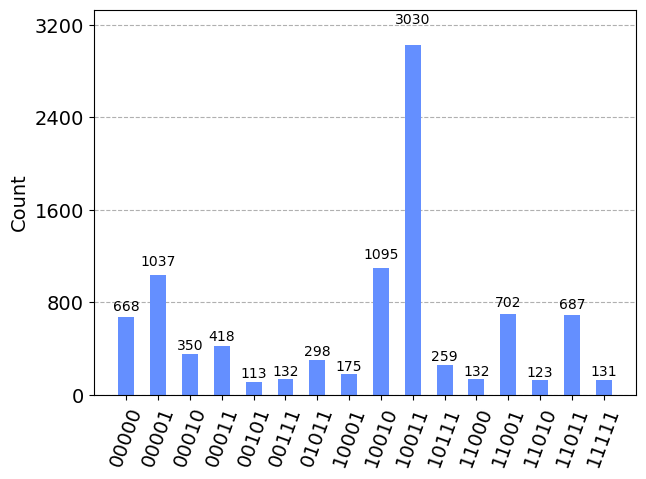

In [41]:
from qiskit.visualization import plot_histogram

# 输出结果
print("优化时间：", endTime - startTime)
print("Optimal parameters:", final_result.x)
print("Optimal value:", final_result.fun)
# 使用最优参数运行量子电路并输出测量结果
final_expectation, final_counts = cost_function(final_result.x, mixers_final)
sorted_dict = {item[0][::-1]: item[1] for item in sorted(final_counts.items(), key=lambda item: item[1], reverse=True)}
# 过滤掉计数小于 100 的结果
filtered_dict = {key: value for key, value in sorted_dict.items() if value >= 100}
print("Final expectation value:", final_expectation)
# print("Final measurement counts:", sorted_dict)
print("Final measurement counts (filtered):", filtered_dict)
# plot_histogram(sorted_dict)
print("mixers:", mixers_final)
# 绘制直方图
plot_histogram(filtered_dict)

In [21]:
# 计算期望值
expectation = 0
for bitstring, count in sorted_dict.items():
    bitstring = invert_counts(bitstring)
    prob = count / 10000
    z_h = np.array([int(bit) for bit in bitstring[(n * N):]])
    s_ik = np.array([int(bit) for bit in bitstring[:(n * N)]]).reshape(n, N)
    E1 = np.sum([2 ** h * z for h, z in enumerate(z_h)])
    E2 = 0
    for j in range(len(bw)):
        for i in range(n):
            constant = 1
            for k in range(N):
                constant = constant * (1 - (s_ik[i, k] - bw[j, k]) ** 2)
            E2 += constant
    E2 = E2
    E3 = 0
    for j in range(m):
        constant1 = 0
        for i in range(n):
            constant2 = 1
            for k in range(N):
                constant2 = constant2 * (1 - (s_ik[i, k] - b[j, k]) ** 2)
            constant1 += p[i, j] * constant2
        constant3 = 0
        for h in range(l):
            constant3 += 2 ** h * z_h[h]
        constant = max(0, constant1 - constant3)
        E3 += (constant) ** 2

    # alpha_s = np.max([0, np.sum(x_ij * p) - np.sum([2 ** h * z for h, z in enumerate(z_h)])])

    E = E1 + E2 + E3

    expectation += E * prob
print(expectation)

5.712699999999998


In [ ]:
expectation = 0
bitstring = "0001101"
z_h = np.array([int(bit) for bit in bitstring[(n * N):]])
s_ik = np.array([int(bit) for bit in bitstring[:(n * N)]]).reshape(n, N)
E1 = np.sum([2 ** h * z for h, z in enumerate(z_h)])
E2 = 0
for j in range(len(bw)):
    for i in range(n):
        constant = 1
        for k in range(N):
            constant = constant * (1 - (s_ik[i, k] - bw[j, k]) ** 2)
        E2 += constant
E2 = K1 * E2
E3 = 0
for j in range(m):
    constant1 = 0
    # print("机器：", j)
    for i in range(n):
        constant2 = 1
        for k in range(N):
            constant2 = constant2 * (1 - (s_ik[i, k] - b[j, k]) ** 2)
        # print("constant2:", constant2)
        # print("p[i,j]:", p[i,j])
        constant1 += p[i, j] * constant2
    # print("constant1:", constant1)
    constant3 = 0
    for h in range(l):
        constant3 += 2 ** h * z_h[h]
    # print("constant3:", constant3)
    constant = max(0, constant1 - constant3)
    E3 += (constant) ** 2

    # alpha_s = np.max([0, np.sum(x_ij * p) - np.sum([2 ** h * z for h, z in enumerate(z_h)])])

E = E1 + K1 * E2 + P * E3
print(E1)
print(E2)
print(E3)
# print(e1)
# print(e2)